In [1]:
import os
os.chdir('/home/research/yu.zihao/pnp/ESE513_Final_Project/')
print(os.getcwd())

/home/research/yu.zihao/pnp/ESE513_Final_Project


In [2]:
from pnp import pnp_admm
from model import Unet
from utils import conv2d_from_kernel, compute_psnr, ImagenetDataset, myplot
import matplotlib.pyplot as plt
import PIL.Image as Image
import torch
import torch.utils.benchmark as benchmark
from traditional_denoiser import bm3d_denoiser, tv_denoiser
import time
import numpy as np
import torch.nn.functional as F


In [3]:
# Perform PnP_ADMM with traditonal denoisers
device = 'cpu'
test_image = Image.open('figs/brookings.webp').convert("RGB")
test_image = ImagenetDataset([]).test_transform(test_image)
channels, h, w = test_image.shape
test_image = test_image.unsqueeze(0).to(device)
kernel_size = 21
kernel_motion_blur = torch.ones((1, kernel_size))
forward, forward_adjoint = conv2d_from_kernel(kernel_motion_blur, channels, device)
y = forward(test_image)

# BM3D
start_time = time.time()
denoised_image_bm3d = pnp_admm(y, forward, forward_adjoint, bm3d_denoiser, num_iter=100, max_cgiter=30, cg_tol=1e-4)
end_time = time.time()
print(f"BM3D Denoiser Execution Time: {end_time - start_time:.2f} seconds")

# TV
start_time = time.time()
denoised_image_tv = pnp_admm(y, forward, forward_adjoint, tv_denoiser, num_iter=100, max_cgiter=30, cg_tol=1e-4)
end_time = time.time()
print(f"TV Denoiser Execution Time: {end_time - start_time:.2f} seconds")

BM3D Denoiser Execution Time: 210.10 seconds
TV Denoiser Execution Time: 59.42 seconds


In [4]:
# Perform PnP_ADMM with CNN denoisers
# U-Net
device = 'cuda:0'
test_image = Image.open('figs/brookings.webp').convert("RGB")
test_image = ImagenetDataset([]).test_transform(test_image)
channels, h, w = test_image.shape
test_image = test_image.unsqueeze(0).to(device)
forward, forward_adjoint = conv2d_from_kernel(kernel_motion_blur, channels, device)
y = forward(test_image)
model = Unet(3, 3, chans=64).to(device)
model.load_state_dict(torch.load('denoiser.pth', map_location=device))
with torch.no_grad():
    model.eval()
    start_time = time.time()
    denoised_image_unet = pnp_admm(y, forward, forward_adjoint, model, num_iter=100, max_cgiter=30, cg_tol=1e-4)
    end_time = time.time()
    denoised_image_unet = denoised_image_unet.clip(0,1)
    print(f"U-Net Denoiser Execution Time: {end_time - start_time:.2f} seconds")



/tmp/ipykernel_196148/434605975.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('denoiser.pth', map_location=device))


U-Net Denoiser Execution Time: 1.07 seconds


In [18]:
# U-Net with different cg_tol
device = 'cuda:0'
test_image = Image.open('figs/brookings.webp').convert("RGB")
test_image = ImagenetDataset([]).test_transform(test_image)
channels, h, w = test_image.shape
test_image = test_image.unsqueeze(0).to(device)
forward, forward_adjoint = conv2d_from_kernel(kernel_motion_blur, channels, device)
y = forward(test_image)
model = Unet(3, 3, chans=64).to(device)
model.load_state_dict(torch.load('denoiser.pth', map_location=device))
with torch.no_grad():
    model.eval()
    start_time = time.time()
    denoised_image_unet_cgtol_1e_7 = pnp_admm(y, forward, forward_adjoint, model, num_iter=100, max_cgiter=30, cg_tol=1e-7)
    end_time = time.time()
    denoised_image_unet_cgtol_1e_7 = denoised_image_unet_cgtol_1e_7.clip(0,1)
    print(f"U-Net Denoiser Execution Time: {end_time - start_time:.2f} seconds")

/tmp/ipykernel_196148/4223472370.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('denoiser.pth', map_location=device))


U-Net Denoiser Execution Time: 1.25 seconds


In [14]:
# U-Net with different max_cgiter. Doesn't necessarily improve the performance
device = 'cuda:0'
test_image = Image.open('figs/brookings.webp').convert("RGB")
test_image = ImagenetDataset([]).test_transform(test_image)
channels, h, w = test_image.shape
test_image = test_image.unsqueeze(0).to(device)
forward, forward_adjoint = conv2d_from_kernel(kernel_motion_blur, channels, device)
y = forward(test_image)
model = Unet(3, 3, chans=64).to(device)
model.load_state_dict(torch.load('denoiser.pth', map_location=device))
with torch.no_grad():
    model.eval()
    start_time = time.time()
    denoised_image_unet_cgiter_100 = pnp_admm(y, forward, forward_adjoint, model, num_iter=100, max_cgiter=100, cg_tol=1e-7)
    end_time = time.time()
    denoised_image_unet_cgiter_100 = denoised_image_unet_cgiter_100.clip(0,1)
    print(f"U-Net Denoiser Execution Time: {end_time - start_time:.2f} seconds")

/tmp/ipykernel_196148/1649859393.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('denoiser.pth', map_location=device))


U-Net Denoiser Execution Time: 1.60 seconds


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.062402166..1.0623124].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06329626..1.057046].


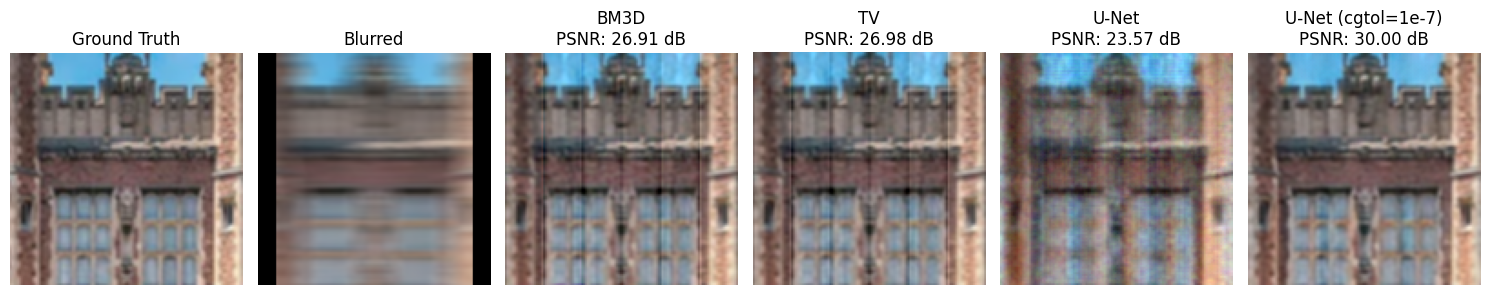

In [19]:
# Plot
ground_truth_image = test_image.cpu().numpy()
blurred_image = F.pad(y, (kernel_size//2, kernel_size//2)).cpu().numpy()
denoised_images = [denoised_image_bm3d, denoised_image_tv, denoised_image_unet.cpu().numpy(), denoised_image_unet_cgiter_100.cpu().numpy()]

# Prepare images for display
ground_truth_image = ground_truth_image.squeeze().transpose(1, 2, 0)
blurred_image = blurred_image.squeeze().transpose(1, 2, 0)
denoised_images = [
    img.cpu().numpy().squeeze().transpose(1, 2, 0) if img.ndim == 4 else img.cpu().numpy().transpose(1, 2, 0)
    for img in [denoised_image_bm3d, denoised_image_tv, denoised_image_unet, denoised_image_unet_cgiter_100]
]

# Create Figure
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(15, 5))
titles = ['Ground Truth', 'Blurred', 'BM3D', 'TV', 'U-Net', 'U-Net (cgtol=1e-7)']

images = [ground_truth_image, blurred_image] + denoised_images
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i], cmap='gray' if images[i].ndim == 2 else None)
    ax.set_title(titles[i])
    
    if i > 1: 
        image_tensor = torch.tensor(images[i]).permute(2, 0, 1).to(test_image.device) if images[i].ndim == 3 else torch.tensor(images[i]).to(test_image.device)
        psnr_value = compute_psnr(image_tensor, test_image)
        ax.set_title(f'{titles[i]}\nPSNR: {psnr_value:.2f} dB')
    
    ax.axis('off')

plt.tight_layout()


# Save 
plt.savefig('comparison_plot.png', dpi=300, bbox_inches='tight')  # Adjust dpi for quality, and bbox_inches to fit content
plt.show()